<a href="https://colab.research.google.com/github/VinayProgram/machine-learning/blob/main/gold_rate_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
import os
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection  import train_test_split
import plotly.express as px
import torch


In [ ]:

# Download latest version
path = kagglehub.dataset_download("nisargchodavadiya/daily-gold-price-20152021-time-series")

# List the contents of the downloaded directory to find the actual data file
print(f"Downloaded dataset to: {path}")
print("Contents of the directory:")
for item in os.listdir(path):
    print(f"- {item}")

# The original code was trying to open a directory as a file, causing IsADirectoryError
# with open(path, 'r') as f:
#     print(f.read())

Using Colab cache for faster access to the 'daily-gold-price-20152021-time-series' dataset.
Downloaded dataset to: /kaggle/input/daily-gold-price-20152021-time-series
Contents of the directory:
- Gold Price.csv


In [ ]:
import pandas as pd
import os

file_name = 'Gold Price.csv'
full_file_path = os.path.join(path, file_name)

df = pd.read_csv(full_file_path)
display(df.head())
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)


,Date,Price,Open,High,Low,Volume,Chg%
0,2026-01-02,135793,136143,137037,135525,51877,0.02
1,2026-01-01,135771,135687,135850,135001,14622,0.23
2,2025-12-31,135454,136526,136527,134866,59050,1.10
3,2025-12-30,133974,133185,134880,132853,36733,1.04
4,2025-12-29,132595,137628,138269,131695,90640,-3.77


In [ ]:
# 1. Convert datetime index to numeric timestamps
X = df.index.view('int64') / 1e9   # seconds since epoch

# 2. Convert price to numeric
y = df['Price'].values.astype('float32')

# 3. Normalize
X_mean, X_std = X.mean(), X.std()
y_mean, y_std = y.mean(), y.std()

X = (X - X_mean) / X_std
y = (y - y_mean) / y_std


In [ ]:
split_idx = int(len(df) * 0.7)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


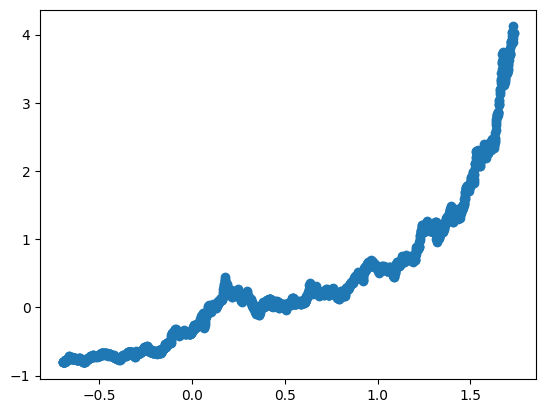

In [ ]:
plt.scatter(X_train,y_train)


In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [ ]:
class GoldRegressor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
model = GoldRegressor()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

epochs = 1000

for epoch in range(epochs):
    model.train()
    preds = model(X_train)
    loss = loss_fn(preds, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        model.eval()
        test_preds = model(X_test)
        test_loss = loss_fn(test_preds, y_test)

        print(f"Epoch {epoch} | Train Loss {loss} | Test Loss {test_loss}")


Epoch 0 | Train Loss 0.8116492033004761 | Test Loss 0.3381919264793396
Epoch 100 | Train Loss 0.061464883387088776 | Test Loss 0.05239170044660568
Epoch 200 | Train Loss 0.0311173927038908 | Test Loss 0.11276920139789581
Epoch 300 | Train Loss 0.020282460376620293 | Test Loss 0.16212774813175201
Epoch 400 | Train Loss 0.01614493876695633 | Test Loss 0.20998694002628326
Epoch 500 | Train Loss 0.014331495389342308 | Test Loss 0.2495933473110199
Epoch 600 | Train Loss 0.013118824921548367 | Test Loss 0.27914103865623474
Epoch 700 | Train Loss 0.012067926116287708 | Test Loss 0.29699692130088806
Epoch 800 | Train Loss 0.011146411299705505 | Test Loss 0.3122730553150177
Epoch 900 | Train Loss 0.010206930339336395 | Test Loss 0.3396659195423126


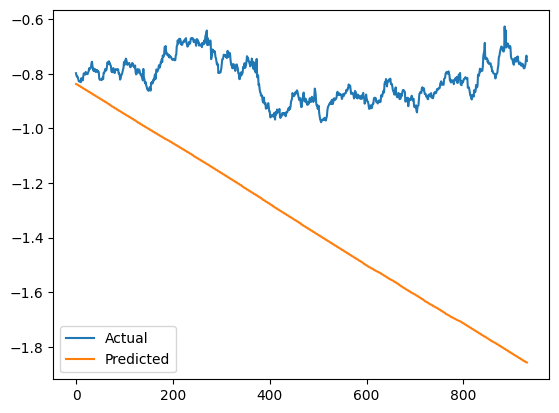

In [ ]:
model.eval()
with torch.inference_mode():
    preds = model(X_test).numpy()

plt.plot(range(len(y_test)), y_test.numpy().squeeze(), label="Actual")
plt.plot(range(len(preds)), preds.squeeze(), label="Predicted")
plt.legend()
plt.show()